In [16]:
import pandas as pd
import math
from pydub import AudioSegment
import matplotlib.pyplot as plt
from glob import glob

In [2]:
csv_path = '../data/tira-asr-hf/metadata-combined.csv'
df=pd.read_csv(csv_path)
df.head()

,start,end,transcription,eaf_source,wav_source,raw_transcription,clip,wav_rawpath,file_name,path,...,wada_snr,nist_stnr,speaker-diarization-3.1,voice-activity-detection,whisper-large-v3,clapipa-transcription-allosaurus,vad_s,drz_s,trans_len,pcnt_speech
0,184240.0,189330.0,mə̀nà càt̪á án âjt̪ɔ́ ŋìðə̀nɔ́ŋ ŋírɔ́t̪...,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,mə̀nà tʃàt̪á án âjt̪ɔ́ ŋìðə̀nɔ́ŋ ŋírɔ́t...,data/tira-asr/clips/HH20220719-1-m03s04ms240-m...,/Users/markjos/Library/CloudStorage/GoogleDriv...,data/tira-asr/clips/HH20220719-1-m03s04ms240-m...,HH20220719-1-m03s04ms240-m03s09ms330.wav,...,14.081620,25.00,0.031 5.009 SPEAKER_00,0.031 3.642 SPEECH;4.098 4.942 SPEECH,ለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለለ...,0.7697,4.455,4.978,64,0.875246
1,271280.0,272310.0,íŋgáŋâɽìɲǎ,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,íŋgáŋâɽìɲǎ,data/tira-asr/clips/HH20220719-1-m04s31ms280-m...,/Users/markjos/Library/CloudStorage/GoogleDriv...,data/tira-asr/clips/HH20220719-1-m04s31ms280-m...,HH20220719-1-m04s31ms280-m04s32ms310.wav,...,5.625207,16.25,0.031 1.094 SPEAKER_00,0.098 1.043 SPEECH,hingga nganginya,0.7191,0.945,1.063,15,0.917476
2,275030.0,276050.0,íŋgáŋâɽìɲǎ,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,íŋgáŋâɽìɲǎ,data/tira-asr/clips/HH20220719-1-m04s35ms030-m...,/Users/markjos/Library/CloudStorage/GoogleDriv...,data/tira-asr/clips/HH20220719-1-m04s35ms030-m...,HH20220719-1-m04s35ms030-m04s36ms050.wav,...,4.222627,20.00,0.031 1.060 SPEAKER_00,0.031 0.959 SPEECH,Gak ngalirnya,0.5247,0.928,1.029,15,0.909804
3,304295.0,305015.0,íŋgáŋâɽìɲǎ,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,íŋgáŋâɽìɲǎ,data/tira-asr/clips/HH20220719-1-m05s04ms295-m...,/Users/markjos/Library/CloudStorage/GoogleDriv...,data/tira-asr/clips/HH20220719-1-m05s04ms295-m...,HH20220719-1-m05s04ms295-m05s05ms015.wav,...,2.189131,3.50,0.031 0.773 SPEAKER_00,0.031 0.723 SPEECH,gone already now,0.1008,0.692,0.742,15,0.961111
4,331510.0,333800.0,ŋìðə̀ní ŋrɔ̀t̪ɔ́ t̪ɔ́wə̀nì,/Users/markjos/Library/CloudStorage/GoogleDriv...,/Users/markjos/Library/CloudStorage/GoogleDriv...,ŋìðə̀ní ŋrɔ̀t̪ɔ́ t̪ɔ́wə̀nì,data/tira-asr/clips/HH20220719-1-m05s31ms510-m...,/Users/markjos/Library/CloudStorage/GoogleDriv...,data/tira-asr/clips/HH20220719-1-m05s31ms510-m...,HH20220719-1-m05s31ms510-m05s33ms800.wav,...,15.113453,26.00,0.031 2.191 SPEAKER_00,0.031 2.191 SPEECH,Ngini ngroto tawoni.,0.7299,2.160,2.160,29,0.943231


In [3]:
df['trans_len']=df['transcription'].str.len()
df['trans_len'][:10]

0    64
1    15
2    15
3    15
4    29
5    29
6    29
7    29
8    29
9    63
Name: trans_len, dtype: int64

In [4]:
df['trans_len_sq']=df['trans_len'].apply(math.log)
df['trans_len_sq']

0        4.158883
1        2.708050
2        2.708050
3        2.708050
4        3.367296
           ...   
23456    3.465736
23457    3.465736
23458    3.295837
23459    2.564949
23460    2.890372
Name: trans_len_sq, Length: 23461, dtype: float64

In [5]:
df[['trans_len', 'trans_len_sq', 'clap_ipa_cos_sim', 'clapipa-transcription-allosaurus', 'nist_stnr', 'wada_snr']].corr('pearson')

,trans_len,trans_len_sq,clap_ipa_cos_sim,clapipa-transcription-allosaurus,nist_stnr,wada_snr
trans_len,1.000000,0.941442,0.135787,0.314145,0.072460,0.066681
trans_len_sq,0.941442,1.000000,0.197276,0.370748,0.064069,0.043705
clap_ipa_cos_sim,0.135787,0.197276,1.000000,0.451776,-0.017467,-0.036883
clapipa-transcription-allosaurus,0.314145,0.370748,0.451776,1.000000,0.061152,-0.006004
nist_stnr,0.072460,0.064069,-0.017467,0.061152,1.000000,0.731698
wada_snr,0.066681,0.043705,-0.036883,-0.006004,0.731698,1.000000


<Axes: >

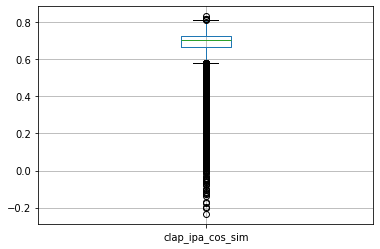

In [6]:
df.boxplot('clap_ipa_cos_sim')

In [7]:
cos_sim_06 = df.loc[
    df['clap_ipa_cos_sim']<0.6,
    ['transcription', 'allosaurus', 'clip', 'clap_ipa_cos_sim', 'clapipa-transcription-allosaurus']
]
cos_sim_06

,transcription,allosaurus,clip,clap_ipa_cos_sim,clapipa-transcription-allosaurus
1,íŋgáŋâɽìɲǎ,ɲ i n k a ŋ n a d i ɲ a,data/tira-asr/clips/HH20220719-1-m04s31ms280-m...,0.523998,0.7191
2,íŋgáŋâɽìɲǎ,i ɲ t a ŋ a ɲ j a,data/tira-asr/clips/HH20220719-1-m04s35ms030-m...,0.527971,0.5247
12,án âjt̪ɔ́ ŋíðə̀nɔ́ŋ ŋʊ̀rɔ́t̪ɛ̌ íŋgáŋâɽìɲà,e t e ɛ n ŋ l o ð ɛ n o n b r a t e a l ɲ a,data/tira-asr/clips/HH20220719-1-m07s06ms700-m...,0.572309,0.5415
14,án âjt̪ɔ́ ŋíðə̀nɔ́ŋ ŋʊ̀rɔ́t̪ɛ̌ íŋgáŋâɽìɲà,b e t̪ ɔ ŋ n a ð i n ɔ ŋ r a k e a e ɲ a,data/tira-asr/clips/HH20220719-1-m07s21ms110-m...,0.571611,0.6405
15,ŋìðə̀nɔ́,NaN,data/tira-asr/clips/HH20220719-1-m07s43ms125-m...,0.563886,0.1548
...,...,...,...,...,...
23324,ŋgɔ́ nɔ́nà ùt̪ùlú nd̪ɔ̀bà ŋgɔ́ nɔ́nà ùt...,ʂ e k a n ʂ i ŋ ɡ a n o t o l o n d ə b a n b ...,data/tira-asr/clips/HH20230608-m56s23ms432-m56...,0.302296,0.5559
23354,ùcùl,o ʂ o,data/tira-asr/clips/HH20221024-m14s56ms510-m14...,0.358558,0.4436
23436,kàrɔ́ àprí t̪àŋó àprí,k a ɡ o ʂ a ŋ m o a p e i t̪ a ʂ,data/tira-asr/clips/HH20210830-m27s01ms608-m27...,0.494360,0.5151
23440,kàrɔ́ t̪àŋòŋ,k a l o t a ŋ m u m j e ʂ,data/tira-asr/clips/HH20210830-m29s13ms648-m29...,0.577541,0.4892


In [8]:
audio=AudioSegment.from_wav('../'+cos_sim_06.iloc[2350]['clip'])
audio

<Axes: >

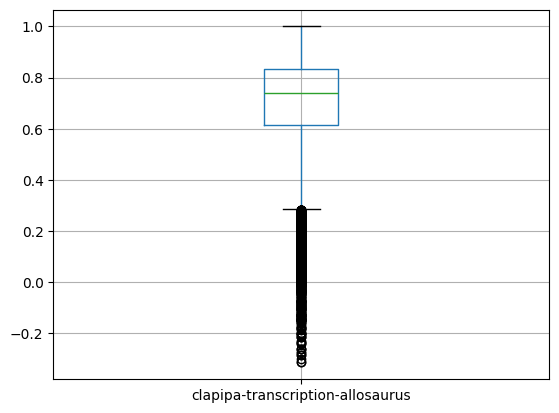

In [9]:
df.boxplot('clapipa-transcription-allosaurus')

In [10]:
clap_allo_06 = df.loc[
    df['clapipa-transcription-allosaurus']<0.4,
    ['transcription', 'allosaurus', 'clip', 'clap_ipa_cos_sim', 'clapipa-transcription-allosaurus']
]
clap_allo_06

,transcription,allosaurus,clip,clap_ipa_cos_sim,clapipa-transcription-allosaurus
3,íŋgáŋâɽìɲǎ,t a ŋ v a,data/tira-asr/clips/HH20220719-1-m05s04ms295-m...,0.616754,0.1008
13,ŋìðə̀nɔ̂ŋ́,n o,data/tira-asr/clips/HH20220719-1-m07s10ms510-m...,0.697518,0.0201
15,ŋìðə̀nɔ́,NaN,data/tira-asr/clips/HH20220719-1-m07s43ms125-m...,0.563886,0.1548
16,ŋìðə̀nɔ́ŋ,d ɔ,data/tira-asr/clips/HH20220719-1-m07s43ms845-m...,0.728962,-0.0338
40,lúmán lɔ̂ń,b a d i d ɔ n,data/tira-asr/clips/HH20220719-1-m17s18ms165-m...,0.550215,0.2166
...,...,...,...,...,...
23320,lùt̪ùlú lìcə̀lò,m a e ʂ a n o p o l o l e ʂ e l o,data/tira-asr/clips/HH20230608-m55s51ms220-m55...,0.470186,0.3695
23361,jâŋú úcùlɔ̀,l a o ə n o,data/tira-asr/clips/HH20221024-m17s52ms775-m17...,0.670752,0.3958
23432,jàŋó,i v a n,data/tira-asr/clips/HH20210830-m26s13ms255-m26...,0.621177,0.2244
23441,kàrɔ́ t̪àŋòŋ,k a t a ŋ,data/tira-asr/clips/HH20210830-m29s20ms672-m29...,0.731578,0.3562


In [11]:
audio=AudioSegment.from_wav('../'+clap_allo_06.iloc[200]['clip'])
audio

In [12]:
clap_allo_06.shape, cos_sim_06.shape, df.shape

((1906, 5), (2357, 5), (23461, 23))

In [18]:
sim_csvs=glob('/Users/markjos/projects/malachor5/data/fleurs/*_sim.csv')
sim_csvs

['/Users/markjos/projects/malachor5/data/fleurs/ha_ng_sim.csv',
 '/Users/markjos/projects/malachor5/data/fleurs/en_us_sim.csv']

In [19]:
sim_df = pd.read_csv(sim_csvs[0])
sim_df.head()

,id,num_samples,path,transcription,raw_transcription,gender,lang_id,language,lang_group_id,similarity
0,302,301440,train/10002175198254707815.wav,nasarorin da vautier ta samu marasa alaka da b...,Nasarorin da Vautier ta samu marasa alaka da b...,1,30,Hausa,3,0.601942
1,302,301440,train/10002175198254707815.wav,nasarorin da vautier ta samu marasa alaka da b...,Nasarorin da Vautier ta samu marasa alaka da b...,1,30,Hausa,3,0.601942
2,1191,218880,train/10004689636339043986.wav,duk da cewa keken dokin sun kunshi katako a je...,Duk da cewa keken dokin sun kunshi katako a je...,0,30,Hausa,3,0.638931
3,728,299520,train/10008007049077819896.wav,callejon del beso alley na kiss. falon baranda...,Callejon del Beso (Alley na Kiss). Falon baran...,1,30,Hausa,3,0.561126
4,887,183360,train/10010906715446836122.wav,antarctica ce nahiya mafi sanyi a duniya wadda...,"Antarctica ce nahiya mafi sanyi a Duniya, wadd...",1,30,Hausa,3,0.620879


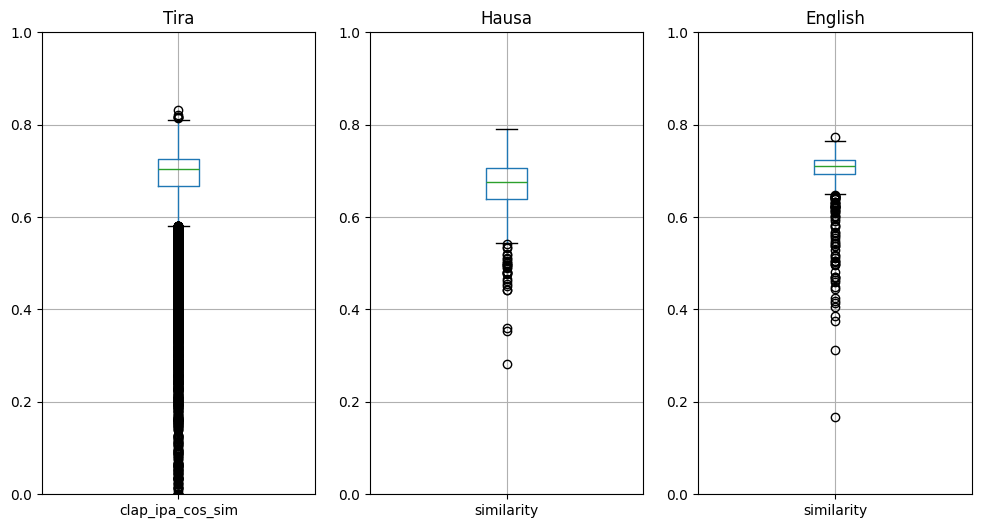

In [22]:
fig, axes = plt.subplots(ncols=len(sim_csvs)+1,figsize=(12,6))
df.boxplot('clap_ipa_cos_sim', ax=axes[0])
axes[0].set_title('Tira')
axes[0].set_ylim(0,1)
for i, csv_path in enumerate(sim_csvs):
    sim_df=pd.read_csv(csv_path)
    sim_df.boxplot('similarity', ax=axes[i+1])
    language=sim_df['language'].iloc[0]
    axes[i+1].set_title(language)
    axes[i+1].set_ylim(0,1)

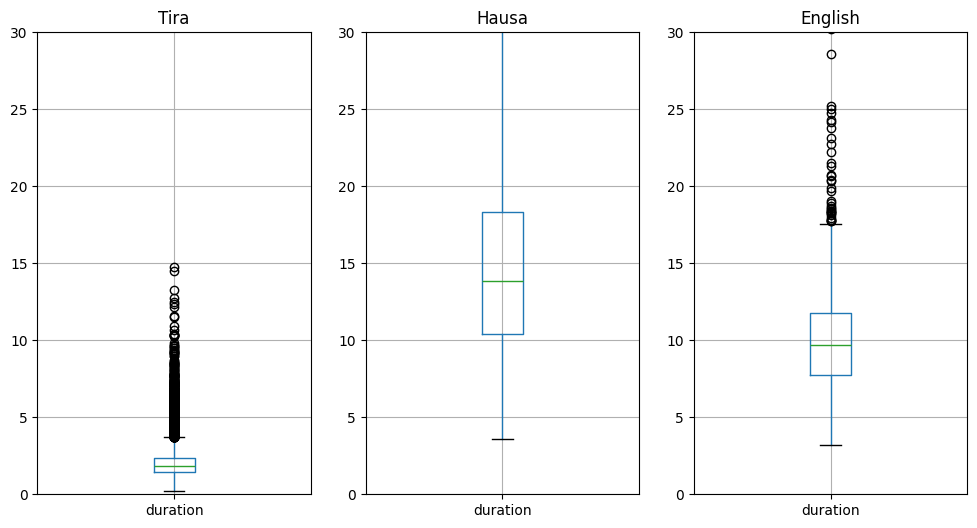

In [26]:
fig, axes = plt.subplots(ncols=len(sim_csvs)+1,figsize=(12,6))
df['duration']=(df['end']-df['start'])/1_000
df.boxplot('duration', ax=axes[0])
axes[0].set_ylim(0,30)

axes[0].set_title('Tira')
for i, csv_path in enumerate(sim_csvs):
    sim_df=pd.read_csv(csv_path)
    sim_df['duration']=sim_df['num_samples']/16_000
    sim_df.boxplot('duration', ax=axes[i+1])
    language=sim_df['language'].iloc[0]
    axes[i+1].set_title(language)
    axes[i+1].set_ylim(0,30)